In [1]:
import os

import numpy as np
import pandas as pd
from typing import Dict, List
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline


# path = "C:\\Users\\jerchen\\PythonDeveloper\\2021 Quant Programming Task\\2021 Quant Programming Task\\mkt_data"
path = "./mkt_data/"
dir_list = os.listdir(path)
all_data = []
for rd in dir_list:
    # print('reading ', rd, '...')
    raw_data = pd.read_csv(path + '/' + rd)
    raw_data['ticker'] = str(rd)[:-4]
    all_data.append(raw_data)

# clean data column name
def cln_df(df: pd.DataFrame):
    cols: List[str] = df.columns
    for col in cols:
        if ' ' in col:
            col_name = col.strip()
            df[col_name] = df[col]
            del df[col]
    return df

all_data = [cln_df(data) for data in all_data]

convert timestamp to datetime object, easier for resample and groupping for analysis

In [2]:
def datetime_from_millis(millisec):
    return pd.Timestamp.fromtimestamp(millisec/1000)
def convert_timestamp(df: pd.DataFrame):
    df['time'] = [datetime_from_millis(x) for x in df['timestamp']]
    return df
all_data = [convert_timestamp(data) for data in all_data]

creating target columns for later usage

In [3]:
def get_target_cols(df:pd.DataFrame):
    df['non_cum_vol'] = df["volume"].diff().fillna(df['volume'].iloc[0])
    df['vol %'] = df['non_cum_vol']/(df['volume'].iloc[-1])
    df['spread'] = df['ask_price'] - df['bid_price']
    df['mid_price'] = (df['ask_price'] + df['bid_price'])/2
    return df


all_data = [get_target_cols(data) for data in all_data]

<h2>1.	Create a visualization to show the following in 15-minute intervals for each stock in the included data - </h2>

    a.	Average spread (Ask - Bid), 

    b.	Average total bin volume as a percent of the full day’s volume 

    c.	Volume-weighted average price (VWAP)

First, let create 15 minutes intervals data for plotting

In [4]:
def create_15min_agg_data(df:pd.DataFrame):
    try:
        data_15min = df.set_index('time').groupby(pd.Grouper(freq='15min')).agg({'spread': 'mean', 'vol %': 'mean', 'vwap': 'mean'})
        data_15min['ticker'] = df['ticker'].iloc[0]
        return data_15min
    except Exception as e:
        print('error at ticker', df['ticker'].iloc[0])
        print(e)
all_15min_data = [create_15min_agg_data(data) for data in all_data.copy()]

In [5]:
agg_data = pd.concat(all_15min_data, axis=0)
agg_data.head()

,spread,vol %,vwap,ticker
time,,,,
2021-10-27 09:30:00,0.053575,0.000280,9.780177,BLDE
2021-10-27 09:45:00,0.028989,0.000312,9.827371,BLDE
2021-10-27 10:00:00,0.022069,0.000204,9.838340,BLDE
2021-10-27 10:15:00,0.017911,0.000240,9.843054,BLDE
2021-10-27 10:30:00,0.016708,0.000280,9.850086,BLDE


<h4> a. Average spread (Ask - Bid) Plot</h4>

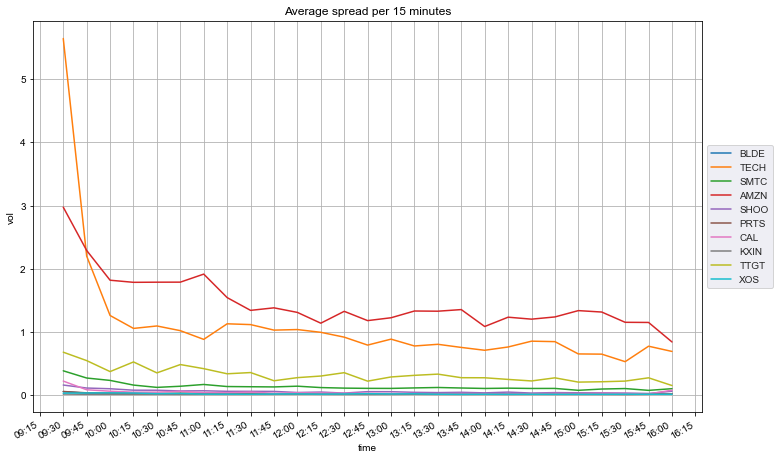

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.pyplot import subplot, subplots
from matplotlib import dates as mdates

def plot_15min_spread(data_15min: List[pd.DataFrame]):
    meta_data = pd.concat(data_15min)
    fig,ax = subplots(figsize=(12, 8))
    sns.set_style("darkgrid")
    sns.lineplot(y = 'spread',
                x = 'time',
                hue='ticker',
                markers=True,
                data=meta_data.reset_index())
    ax.set(title='Average spread per 15 minutes', ylabel="vol")

    xformatter = mdates.DateFormatter('%H:%M')
    xlocator = mdates.MinuteLocator(byminute=[0,15, 30, 45], interval = 1) ##Set ticks to show 00 and 30 minutes only
    ## Set xtick labels to appear every 30 minutes
    ax.xaxis.set_major_locator(xlocator)

    ## Format xtick labels as HH:MM
    ax.xaxis.set_major_formatter(xformatter)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.autofmt_xdate()
    ax.grid(True)
plot_15min_spread(all_15min_data)

<h4>    b.	Average total bin volume as a percent of the full day’s volume </h4>


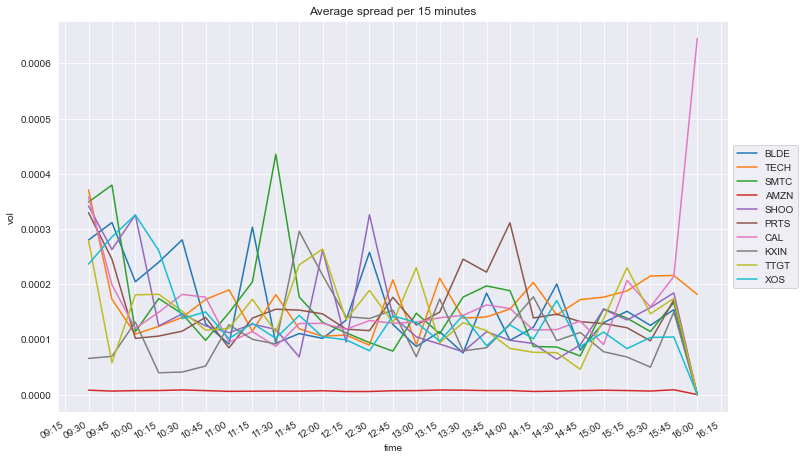

In [7]:

def plot_15min_volume(data_15min: List[pd.DataFrame]):
    meta_data = pd.concat(data_15min)
    fig,ax = subplots(figsize=(12, 8))
    sns.set_style("darkgrid")
    sns.lineplot(y = 'vol %',
                x = 'time',
                hue='ticker',
                markers=True,
                data=meta_data.reset_index())
    ax.set(title='Average spread per 15 minutes', ylabel="vol")

    xformatter = mdates.DateFormatter('%H:%M')
    xlocator = mdates.MinuteLocator(byminute=[0,15, 30, 45], interval = 1) ##Set ticks to show 00 and 30 minutes only
    ## Set xtick labels to appear every 30 minutes
    ax.xaxis.set_major_locator(xlocator)

    ## Format xtick labels as HH:MM
    ax.xaxis.set_major_formatter(xformatter)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.autofmt_xdate()
    ax.grid(True)
plot_15min_volume(all_15min_data)

<h4>    c.	Volume-weighted average price (VWAP) </h4>


due to vwap value for each stock vary drastically, thus here presented individual graph instead of aggregate one 

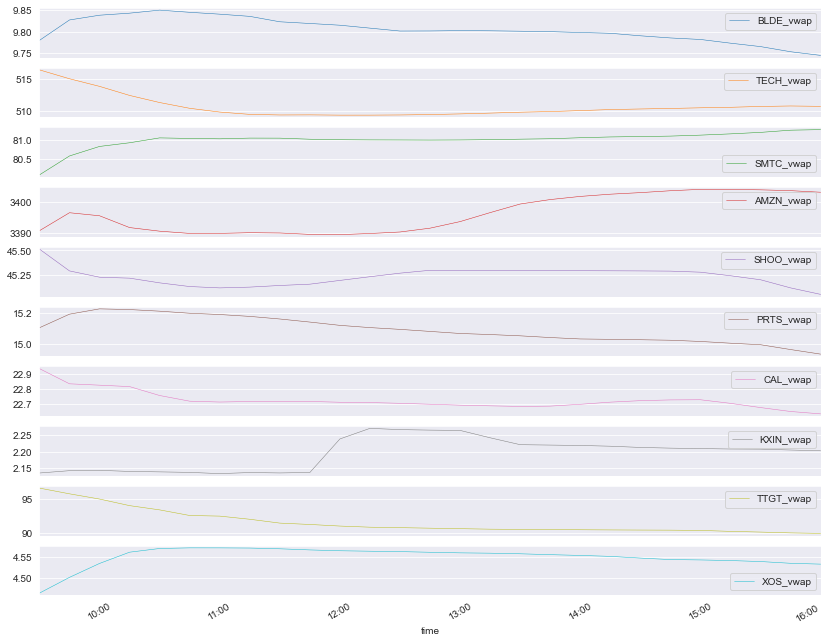

In [8]:


def plot_vwap(pdf):
    dats = pd.DataFrame()
    for data in pdf:
        if 'time' not in dats.columns:
            dats['time'] = data.index            
        ticker = data['ticker'].iloc[0]
        dats[ticker + '_vwap'] = data['vwap'].values
    dats = dats.set_index('time')
#     print(dats.head())
    cols_plot = list(dats.columns)
    axes = dats[cols_plot].plot(linewidth=0.5, figsize=(14, 12), subplots=True)
    for ax in axes:
        ax.set_ylabel('')
plot_vwap(all_15min_data)

<h2> Question 2 - Cross Sectional Regression</h2>



<h4> First step - Create Response Variable </h4>

Creating the required columns for future usage

In [9]:
from copy import deepcopy
all_data_2 = deepcopy(all_data) 

In [10]:
def create_model_variables(pdf:pd.DataFrame):    
    pdf['mid_price'] = (pdf['bid_price'] + pdf['ask_price'])/2
    pdf['denom'] = pdf['ask_price'] - pdf['bid_price']
    mask = pdf['denom'] > 0
    pdf = pdf[mask]
    pdf = pdf.reset_index(drop=True)
    return pdf

all_data_2 = [create_model_variables(df) for df in all_data_2]


In [11]:
# check the update data
all_data_2[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6191 entries, 0 to 6190
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           6191 non-null   int64         
 1   ticker              6191 non-null   object        
 2   bid_price           6191 non-null   float64       
 3   bid_size            6191 non-null   int64         
 4   bid_exchange        6191 non-null   object        
 5   ask_price           6191 non-null   float64       
 6   ask_size            6191 non-null   int64         
 7   ask_exchange        6191 non-null   object        
 8   trade_price         6191 non-null   float64       
 9   trade_size          6191 non-null   int64         
 10  trade_exchange      6191 non-null   object        
 11  volume              6191 non-null   int64         
 12  notional_volume     6191 non-null   float64       
 13  vwap                6191 non-null   float64     

Next, calculate the normalized mid price return from the time of trade to the midpoint price at 10 seconds after the time of a trade.

In [12]:

from collections import deque
from typing import Deque

# runtime O(n)
def get_t_p_10_midprc(pdf: pd.DataFrame):
    time, midprcs = pdf['time'], pdf['mid_price']
    qt: Deque = deque([]) # we use queue we keep tracks the next t+10 time, initialized with deque here
    time_10 = [0]*len(time)
    price_10 = [0]*len(midprcs)
    prevt = time[0]
    prevp = midprcs[0]
    
    for idx, currt in enumerate(time):
        try:
            qt.append(idx) # using que to keep tracks on the idx of time that smaller than t+10
            
            # whenever theres a time larger than the que's (t+10), we find the 'next' t that larger than t+10
            while qt and currt > (time[qt[0]] + pd.Timedelta('10s')): 
                time_10[qt[0]] = prevt # thus, when we found time > t+10, we store the previous time 
                price_10[qt[0]] = prevp # store previous mid price
                qt.popleft()
            prevt = currt 
            prevp = midprcs[idx] 
        except Exception as e:
            print('err', e, end=',')
        
    # we might have left queue due to time already larger than the last time we have
    while qt: 
        time_10[qt[0]] = prevt
        price_10[qt[0]] = prevp
        qt.popleft()
    return time_10, price_10

# after getting the mid price t+10 series, we could calculate the rest and create our response data
def create_respond_data(pdf:pd.DataFrame):
    timep10, prcp10 = get_t_p_10_midprc(pdf)
    respond = pdf.copy()
    respond['timep10'] = timep10
    respond['prcp10'] = prcp10
    respond['mid_prc_ret'] = (respond['mid_price']/respond['prcp10']) -  1
    respond['mid_prc_norm_ret'] = respond['mid_prc_ret']/respond['denom']
    respond['time'] = respond['time']
    # pdf.drop(columns=['timep10','prcp10','mid_prc_ret','denom'], inplace=True)
    respond = respond[['time', 'mid_prc_norm_ret']]
    return respond
    
respond_data = [create_respond_data(df) for df in all_data_2]



<h4> Second step - Create Predictors </h4>
Creating the following predictors for modelling

- Bid Offer Imbalance, calculated as (Nbb_agg_size – Nbo_agg_size )/(Nbb_agg_size + Nbo_agg_size) 

- Trade sign:  <br>
        1 if the last trade price is above the average of bid and ask price <br>
        -1 if the last trade price is below the average of bid and ask price

- Trade Size imbalance over the last 10 seconds: Trade size imbalance for any period can be calculated as: 
        Sum ( Trade Sign x Trade Size ) 


In [13]:
def create_predictors(pdf:pd.DataFrame):
    predictor = pd.DataFrame(index=pdf.index)
    predictor['time'] = pdf['time']
    predictor['bid_offer_imbal'] = (pdf['nbb_agg_size'] - pdf['nbo_agg_size'])/(pdf['nbb_agg_size'] + pdf['nbo_agg_size'])
    predictor['trade_sign'] = np.where(pdf['trade_price'] > pdf['mid_price'], 1, -1)
    predictor['trade_sz_imbal'] = predictor['trade_sign']*pdf['trade_size']
    predictor['trade_sz_imbal_10s'] = predictor.set_index('time')['trade_sz_imbal'].rolling('10s').sum().values
    predictor['ticker'] = pdf['ticker']
    predictor['timestamp'] = pdf['timestamp']
    return predictor
predictors = [create_predictors(data) for data in all_data_2]

aggregate responses and predictors for modelling

In [14]:
agg_predictors = pd.concat(predictors).set_index('time')
agg_response = pd.concat(respond_data).set_index('time')

print(agg_predictors.shape)
print(agg_response.shape)

(195107, 6)
(195107, 1)


building linear regression model

In [52]:
from sklearn import linear_model
from scipy.stats import t as scpt
import numpy as np

from sklearn.linear_model import LinearRegression

class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        # try:
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        mse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        self.se = np.array([
            np.sqrt(np.diagonal(mse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(mse.shape[0])
                    ])

        self.t = self.coef_ / self.se
        self.p = 2 * (1 - scpt.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self
    

In [53]:
# initialize date range for looping
start_time_range = pd.date_range("2021-10-27 09:30:00", "2021-10-27 15:59:50", freq="10s").time
end_time_range = pd.date_range("2021-10-27 09:30:10", "2021-10-27 16:00:00", freq="10s").time
betas = []
stats = []
for ind, (start, end) in enumerate(zip(start_time_range, end_time_range)): # since just linear model, we loop thru all time interval and run regression
    if ind/100 == ind//100:
        print("running", ind, end=',')
    X = agg_predictors.loc[start:end] # use the date range to select time periods
    X = X[['bid_offer_imbal','trade_sign','trade_sz_imbal_10s']]
    y = agg_response.loc[start:end]
    
    ols = LinearRegression()
    reg = ols.fit(X, y)
    betas.append(reg.coef_)
    stats.append((
        reg.t,
        reg.p,
        reg.se))
    


running 0,running 100,running 200,running 300,running 400,running 500,running 600,running 700,running 800,running 900,running 1000,running 1100,running 1200,running 1300,running 1400,running 1500,running 1600,running 1700,running 1800,running 1900,running 2000,running 2100,running 2200,running 2300,

we can see that the runtime didn't taking too long when using modified sklearn models. We could boost the runtime by using the numeric solution of OLS, we will exploit that later. <br> Lets check the coefficient and it's t-stats first

check coefficients

In [54]:
betas = [b.tolist()[0] for b in betas]
coef_sum = pd.DataFrame(betas, 
                       index=end_time_range,
                       columns=['bid_offer_imbal','trade_sign','trade_sz_imbal_10s'])
coef_sum

,bid_offer_imbal,trade_sign,trade_sz_imbal_10s
09:30:10,-0.000074,-0.000949,9.045904e-07
09:30:20,-0.000017,-0.000038,1.251261e-07
09:30:30,-0.000155,-0.000030,-1.675620e-07
09:30:40,-0.000038,-0.000289,-1.877379e-07
09:30:50,0.000018,-0.000108,-1.390442e-07
...,...,...,...
15:59:20,0.000462,-0.006205,-3.872565e-06
15:59:30,-0.049054,-0.009675,-6.124656e-06
15:59:40,-0.044886,-0.013627,-3.599731e-06
15:59:50,-0.017782,-0.008984,-1.622089e-05


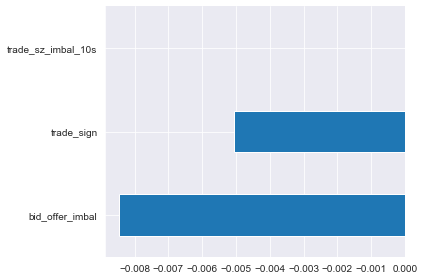

In [55]:
coef_sum.mean().plot.barh()
sns.despine()
plt.tight_layout()

statistic summary

In [40]:
print('coefficients summary: ')
print(' ---mean--- ')
print(coef_sum.mean())
print(' ---std--- ')
coef_sum.mean().div(coef_sum.std())

coefficients summary: 
 ---mean--- 
bid_offer_imbal      -0.008468
trade_sign           -0.005056
trade_sz_imbal_10s   -0.000003
dtype: float64
 ---std--- 


bid_offer_imbal      -0.124406
trade_sign           -0.142873
trade_sz_imbal_10s   -0.065852
dtype: float64

In [65]:
tstats1 = np.mean([t[0].tolist()[0] for t in stats], axis=0)
pstats = np.mean([t[1].tolist()[0] for t in stats], axis=0)
stderr = np.mean([t[2].tolist()[0] for t in stats], axis=0)

print('statistic summary: ')
stats_sum = pd.DataFrame([tstats1, pstats, stderr], 
                       index=['t statistic', 'p value', 'standard error'],
                       columns=['bid_offer_imbal','trade_sign','trade_sz_imbal_10s'])
print(stats_sum)

statistic summary: 
                bid_offer_imbal  trade_sign  trade_sz_imbal_10s
t statistic           -1.376833   -1.399138           -0.386746
p value                0.216065    0.251821            0.286115
standard error         0.006482    0.002787            0.000005


We can see that all coefficient are negative, and the t-stats are pretty small

4.	Calculate the 15-second volatility (standard deviation of mid price returns) for SHOO in each 30 minute interval. Present the volatility in annualized terms. 

In [ ]:
shoo_data = pd.read_csv(path+'SHOO.csv')
shoo_data = cln_df(shoo_data)
shoo_data = convert_timestamp(shoo_data)
shoo_data = get_target_cols(shoo_data)
shoo_data = create_model_variables(shoo_data)
shoo_data.columns

In [ ]:
shoo_data['mid_prc_ret'] = shoo_data['mid_price'].pct_change(1)
shoo_data.head()

In [ ]:
shoo_data = shoo_data[['time','mid_prc_ret']]
shoo_data

In [ ]:
import math

gp = shoo_data.set_index('time').groupby(pd.Grouper(freq='30min'))
agg_vol = []
for name, group in gp:
    group['interval'] = name
    group['15 sec volaltility'] = group.rolling('15s').std().fillna(0)
    group['15 sec volaltility'] = group['15 sec volaltility']*math.sqrt(252)
    agg_vol.append(group)
agg_vol = pd.concat(agg_vol)
# agg_vol = agg_vol.fillna(0)
# agg_vol = agg_vol.rename(columns={'mid_prc_ret':'15 sec volaltility'})
agg_vol

In [ ]:
from matplotlib import dates as mdates
from matplotlib.pyplot import subplot, subplots
sns.set_theme()
fig,ax = subplots(figsize=(16, 10))
sns.lineplot(y = '15 sec volaltility',
 x = 'time',
 hue='interval',
 data=agg_vol,
 lw=.5
 )
ax.set(title='15 seconds volatility every 30 minutes', ylabel="vol")

xformatter = mdates.DateFormatter('%H:%M')
xlocator = mdates.MinuteLocator(byminute=[0,30], interval = 1) ##Set ticks to show 00 and 30 minutes only

## Set xtick labels to appear every 30 minutes
ax.xaxis.set_major_locator(xlocator)

## Format xtick labels as HH:MM
ax.xaxis.set_major_formatter(xformatter)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.autofmt_xdate()
ax.grid
